# F1 Analysis

## Start

In [ ]:
#USEFUL CODES FOR COLAB

#from google.colab import drive
#drive.mount ('/content/gdrive')
#cd /content/gdrive/MyDrive/DataScience/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

In [ ]:
circuits = pd.read_csv('data/circuits.csv')
#constructor_results = pd.read_csv('data/constructor_results.csv')
#constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructors = pd.read_csv('data/constructors.csv')
driver_standings = pd.read_csv('data/driver_standings.csv')
drivers = pd.read_csv('data/drivers.csv')
#lap_times = pd.read_csv('data/lap_times.csv')
pit_stops = pd.read_csv('data/pit_stops.csv')
qualifying = pd.read_csv('data/qualifying.csv')
races = pd.read_csv('data/races.csv')
results = pd.read_csv('data/results.csv')
#seasons = pd.read_csv('data/seasons.csv')
#sprint_results = pd.read_csv('data/sprint_results.csv')
#status = pd.read_csv('data/status.csv')
cluster = pd.read_csv('data/cluster.csv')

## Descriptive Analysis

### Distributions

In [ ]:
#status code engine failure, non-ignition and engine fire
engine = results.loc[(results['statusId'] == 5)|(results['statusId'] == 56)|(results['statusId'] == 129)] 

plt.figure(figsize=(20,10))
sns.distplot(engine['laps'], kde=False, bins=200)
plt.title('Distribution of engine failure', fontsize = 20)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(pit_stops['lap'], kde=True, bins=200)
plt.title('Distribution of pit stops', fontsize = 20)
plt.show()

In [ ]:
winner = results.loc[results['positionOrder'] == 1]
plt.figure(figsize=(20,10))
sns.distplot(winner['laps'], kde=True, bins=200)
plt.title('Distribution of number of laps to win grand prix', fontsize = 20)
plt.show()

### Correlation

In [ ]:


position = pd.merge(results, qualifying, on=['raceId', 'driverId'])
position = position[['raceId', 'driverId', 'position_y', 'grid', 'positionOrder']]
position = position.rename(columns={"position_y": "qualifying", "positionOrder": "race"})
features= list(['qualifying','grid','race'])

plt.figure(figsize=(15,8))
sns.heatmap(position[features].corr(), cmap = 'Greens', annot = True, annot_kws={"fontsize": 18})
plt.title('Heatmap', fontsize = 20)
plt.show()

### Maps

In [ ]:
results = results[['resultId', 'raceId', 'constructorId', 'positionOrder']]
constructors = constructors[['constructorId', 'name']]
races = races[['raceId', 'circuitId']]

winners = results.loc[results['positionOrder'] == 1]
constructor_winners = pd.merge(winners, constructors, on=['constructorId'])

constructor_winners = pd.merge(constructor_winners, races, on=['raceId'])
constructor_winners = pd.merge(constructor_winners, circuits, on=['circuitId'])
constructor_winners = constructor_winners.rename(columns={"name_x": "constructor", "name_y": "circuit"})


constructor_winners = constructor_winners[['constructor', 'circuit', 'location', 'country',  'lat', 'lng']]

wins_count = pd.DataFrame(constructor_winners.value_counts())
wins_count = wins_count.reset_index()
wins_count.columns = ['constructor', 'circuit', 'location', 'country','lat', 'lng', 'count']

ferrari_wins = wins_count.loc[wins_count['constructor']=='Ferrari']
ferrari_winners =  constructor_winners.loc[constructor_winners['constructor']=='Ferrari']

stateWins = ferrari_wins[['country', 'count']]
stateWins = stateWins.groupby(['country']).sum()
stateWins = stateWins.reset_index()
stateWins

In [ ]:
ferrari_winners['country'].value_counts().plot.bar(figsize = (20, 10), color = 'red')
#ferrari_winners['location'].value_counts().plot(kind = 'bar', color ='green')

In [ ]:
fig = go.Figure(data=go.Choropleth(
    locations = stateWins['country'],
    locationmode = 'country names',
    z = stateWins['count'],
    colorscale = 'Reds',
    marker_line_color = 'black',
    marker_line_width = 0.5,
))

fig.update_layout(
    title_text = 'Vittorie scuderia Ferrari',
    title_x = 0.5,
    geo=dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    )
)

In [ ]:
# Create a world map to show distributions of users 
import folium
from folium.plugins import MarkerCluster
#empty map
world_map= folium.Map(tiles="cartodbpositron")
marker_cluster = MarkerCluster().add_to(world_map)
#for each coordinate, create circlemarker of user percent
for i in range(len(ferrari_wins)):
        lat = ferrari_wins.iloc[i]['lat']
        long = ferrari_wins.iloc[i]['lng']
        radius=5
        popup_text = """Location: {}<br>
                     Winner: {}<br>"""
        popup_text = popup_text.format(ferrari_wins.iloc[i]['location'],
                                   ferrari_wins.iloc[i]['count']
                                   )
        folium.CircleMarker(location = [lat, long], radius=radius, popup= popup_text, fill =True).add_to(marker_cluster)
#show the map
world_map

## Clustering

### Two-Dimensional Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

driver_standings = driver_standings.loc[(driver_standings['raceId']>=841)]

stardard_driver = sc.fit_transform(driver_standings[["points", "position"]])
driver_standings[["points", "position"]] = stardard_driver
driver_standings = driver_standings.groupby(['driverId']).mean()
driver_standings


In [ ]:
from sklearn.cluster import KMeans
x = driver_standings.iloc[:, [2, 3]].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)

plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

In [ ]:

km = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.figure(figsize=(15,8))
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 100, c = 'silver', label = 'mids')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 100, c = 'brown', label = 'lasts')
plt.scatter(x[y_means == 2, 0], x[y_means == 2, 1], s = 100, c = 'gold', label = 'bests')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centroid')

plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('Point')
plt.ylabel('Position')
plt.legend()
plt.show()


In [ ]:
features= list(['points','position'])
#position['qualifying'].corr(position['race'])

plt.figure(figsize=(15,8))
sns.heatmap(driver_standings[features].corr(), cmap = 'Greens', annot = True, annot_kws={"fontsize": 18})
plt.title('Heatmap', fontsize = 20)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.cluster import KMeans

cluster = cluster.loc[cluster['maxSpeed']!=0]

stardard_cluster = sc.fit_transform(cluster[["percThrottle", "maxSpeed"]])
cluster[["percThrottle", "maxSpeed"]] = stardard_cluster


x = cluster.iloc[:, [3, 4]].values

wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)

plt.figure(figsize=(20,8))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')


In [ ]:

km = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)

plt.figure(figsize=(15,8))
plt.scatter(x[y_means == 0, 0], x[y_means == 0, 1], s = 100, c = 'silver', label = 'slowests')
plt.scatter(x[y_means == 1, 0], x[y_means == 1, 1], s = 100, c = 'brown', label = 'fastests')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], s = 50, c = 'blue' , label = 'centroid')

plt.title('K Means Clustering', fontsize = 20)
plt.xlabel('percentage Full Throttle')
plt.ylabel('Speed')
plt.legend()
plt.show()


### Multi-Dimensional Clustering

In [ ]:
result_standings = pd.merge(results, races, on=['raceId'])

def numRaces(driverId):
  driver = results.loc[(results['driverId']==driverId)]
  numRaces = len(driver.drop_duplicates())
  return numRaces

#ritorna il numero di vittorie
def numWins(driverId):
  #prende i risultati del driverId
  driver = results.loc[(results['driverId']==driverId)] 
  #prende le gare in cui è arrivato primo
  wins = driver.loc[(driver['positionOrder']==1)]
  #il numero di righe corrisponde alle vittore
  numWins = len(wins)
  return numWins

#analogo a numWins(id)
def numSeconds(driverId):
  driver = results.loc[(results['driverId']==driverId)] 
  seconds = driver.loc[(driver['positionOrder']==2)]
  numSeconds = len(seconds)
  return numSeconds

#analogo a numWins(id)
def numThirds(driverId):
  driver = results.loc[(results['driverId']==driverId)] 
  thirds = driver.loc[(driver['positionOrder']==3)]
  numThirds = len(thirds)
  return numThirds

def bestPosition(driverId):
  driver = results.loc[(results['driverId']==driverId)]
  bestPosition = driver['positionOrder'].min()
  return bestPosition

def maxWinsSingleYear(driverId):
  #prende i risultati del driverId
  driver = result_standings.loc[(result_standings['driverId']==driverId)] 
  #prende le gare in cui è arrivato primo
  wins = driver.loc[(driver['positionOrder']==1)]
  winsForYear = wins.groupby(['year']).sum()
  maxWinsSingleYear = winsForYear['positionOrder'].max() 
  return maxWinsSingleYear

In [ ]:
#analogo a numWins(id) ma prendo la griglia di partenza
def numPoles(driverId):
  driver = results.loc[(results['driverId']==driverId)] 
  poles = driver.loc[(driver['grid']==1)]
  numPoles = len(poles)
  return numPoles

#analogo a numPoles(id)
def numSecondsQuali(driverId):
  driver = results.loc[(results['driverId']==driverId)] 
  secondsQuali = driver.loc[(driver['grid']==2)]
  numSecondsQuali = len(secondsQuali)
  return numSecondsQuali

#analogo a numPoles(id)
def numThirdsQuali(driverId):
  driver = results.loc[(results['driverId']==driverId)] 
  thirdsQuali = driver.loc[(driver['grid']==3)]
  numThirdsQuali = len(thirdsQuali)
  return numThirdsQuali



In [ ]:
standings = pd.merge(driver_standings, races, on=['raceId'])

#massima posizione in classifica raggiunta (anche solo per una gara)
def bestRank(driverId):
  driver = standings.loc[(standings['driverId']==driverId)] 
  rank = driver.groupby(['year']).min()
  bestRank = rank['position'].min()
  return bestRank

def round(year):
  standingsYear = standings.loc[(standings['year']==year)]
  round = standingsYear.loc[standingsYear['round'].idxmax()]
  roundNum = round['round']
  return roundNum

#massima posizione in classifica finale
def bestFinalRank(driverId):
  driver = standings.loc[(standings['driverId']==driverId)]
  totalRound = driver[['year', 'round', 'position']]  
  df = pd.DataFrame()
  df = totalRound
  dfShort = df[['year', 'round']]
  dfGroup = dfShort.groupby(['year']).max()

  jointable = dfGroup.merge(df,how='left', on='year', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
  jointableShort = jointable.loc[jointable['round_x'] ==jointable['round_y']]
  bestFinalRank = jointableShort['position'].min()
  return bestFinalRank

def numWorldChampionship(driverId):
  driver = standings.loc[(standings['driverId']==driverId)]
  totalRound = driver[['year', 'round', 'position']]
  df = pd.DataFrame()
  df = totalRound
  dfShort = df[['year', 'round']]
  dfGroup = dfShort.groupby(['year']).max()

  jointable = dfGroup.merge(df,how='left', on='year', left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
  jointableShort = jointable.loc[jointable['round_x'] ==jointable['round_y']]
  worldChampionship = jointableShort.loc[jointableShort['position']==1]
  numWorldChampionship = len(worldChampionship)
  return numWorldChampionship

#ritorna il totale dei punti conquistati
def totalPoints (driverId):
  driver = standings.loc[(standings['driverId']==driverId)]
  points = driver.groupby(['year']).max() 
  totalPoints = points['points'].sum()
  return totalPoints

In [ ]:
drivers

In [ ]:
data = pd.DataFrame(columns= ['driverId', 'numRaces', 'numWins', 'numSeconds', 'numThirds', 'bestPosition', 'maxWinsSingleYear', 'numPoles', 'numSecondsQuali', 'numThirdsQuali', 'bestRank', 'bestFinalRank', 'numWorldChampionship', 'totalPoints'])

data['driverId'] = drivers['driverId']

data['numRaces'] = data.apply(lambda x: numRaces(x['driverId']), axis=1)

data['numWins'] = data.apply(lambda x: numWins(x['driverId']), axis=1)
data['numWins'] = data['numWins'].fillna(0)

data['numSeconds'] = data.apply(lambda x: numSeconds(x['driverId']), axis=1)
data['numSeconds'] = data['numSeconds'].fillna(0)

data['numThirds'] = data.apply(lambda x: numThirds(x['driverId']), axis=1)
data['numThirds'] = data['numThirds'].fillna(0)

data['bestPosition'] = data.apply(lambda x: bestPosition(x['driverId']), axis=1)
data['bestPosition'] = data['bestPosition'].fillna(0)

data['maxWinsSingleYear'] = data.apply(lambda x: maxWinsSingleYear(x['driverId']), axis=1)
data['maxWinsSingleYear'] = data['maxWinsSingleYear'].fillna(0)
data['maxWinsSingleYear'] = data['maxWinsSingleYear'].astype(int)

data['numPoles'] = data.apply(lambda x: numPoles(x['driverId']), axis=1)
data['numPoles'] = data['numPoles'].fillna(0)

data['numSecondsQuali'] = data.apply(lambda x: numSecondsQuali(x['driverId']), axis=1)
data['numSecondsQuali'] = data['numSecondsQuali'].fillna(0)

data['numThirdsQuali'] = data.apply(lambda x: numThirdsQuali(x['driverId']), axis=1)
data['numThirdsQuali'] = data['numThirdsQuali'].fillna(0)

data['bestRank'] = data.apply(lambda x: bestRank(x['driverId']), axis=1)
data['bestRank'] = data['bestRank'].fillna(25)
data['bestRank'] = data['bestRank'].astype(int)

data['bestFinalRank'] = data.apply(lambda x: bestFinalRank(x['driverId']), axis=1)
data['bestFinalRank'] = data['bestFinalRank'].fillna(25)
data['bestFinalRank'] = data['bestFinalRank'].astype(int)

data['numWorldChampionship'] = data.apply(lambda x: numWorldChampionship(x['driverId']), axis=1)
data['numWorldChampionship'] = data['numWorldChampionship'].fillna(0)
data['numWorldChampionship'] = data['numWorldChampionship'].astype(int)
data['totalPoints'] = data.apply(lambda x: totalPoints(x['driverId']), axis=1)


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

stardard_data = sc.fit_transform(data[['numRaces', 'numWins', 'numSeconds', 'numThirds', 'bestPosition', 'maxWinsSingleYear', 'numPoles', 'numSecondsQuali', 'numThirdsQuali', 'bestRank', 'bestFinalRank', 'numWorldChampionship', 'totalPoints']])
data[['numRaces', 'numWins', 'numSeconds', 'numThirds', 'bestPosition', 'maxWinsSingleYear', 'numPoles', 'numSecondsQuali', 'numThirdsQuali', 'bestRank', 'bestFinalRank', 'numWorldChampionship', 'totalPoints']] = stardard_data
data

In [ ]:
from sklearn.cluster import KMeans

x = data.drop(["driverId"], axis=1).values
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(15,5))
plt.plot(range(1, 11), wcss)
plt.title('K-Means Clustering(The Elbow Method)', fontsize = 20)
plt.xlabel('All')
plt.ylabel('wcss')
plt.show()


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver="auto").fit(x)
pca_x = pca.transform(x)

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
ymeans = kmeans.fit_predict(x)

plt.figure(figsize=(15,8))
plt.title('Cluster of PCAs', fontsize = 30)

plt.scatter(pca_x[ymeans == 0, 0], pca_x[ymeans == 0, 1], s = 100, c = 'pink')
plt.scatter(pca_x[ymeans == 1, 0], pca_x[ymeans == 1, 1], s = 100, c = 'orange')
plt.scatter(pca_x[ymeans == 2, 0], pca_x[ymeans == 2, 1], s = 100, c = 'lightgreen')
plt.scatter(pca_x[ymeans == 3, 0], pca_x[ymeans == 3, 1], s = 100, c = 'blue')


centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], s = 50, c = 'black', label="center")

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

In [ ]:


pca = PCA()



x = data.drop(["driverId"], axis=1).values
X_train_pca = pca.fit_transform(x)



exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)


plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')

plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')

plt.xlabel('Principal component index')

plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
from numpy.linalg import eigh

x = data.drop(["driverId"], axis=1).values

cov_matrix = np.cov(x, rowvar=False)

egnvalues, egnvectors = eigh(cov_matrix)



total_egnvalues = sum(egnvalues)

var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]



cum_sum_exp = np.cumsum(var_exp)

plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')

plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')

plt.xlabel('Principal component index')

plt.legend(loc='best')

plt.tight_layout()

plt.show()

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

plt.figure(figsize=(15,8))
visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer


# Instantiate the clustering model and visualizer
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

plt.figure(figsize=(15,8))
visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show()

## Classification

### Hamilton - Verstappen classification


In [ ]:
years = [2019, 2020, 2021]
drivers = [44,33]
races = ['Italy', 'Spain', 'Baharain', 'Abu Dhabi', 'Belgium', 'British']
lapsArray = []
for y in years:
  for r in races:
    session = ff1.get_session(y, r, 'R')
    session.load()
    for d in drivers:
      print('YEAR: ', y, ' RACE:', r, ' DRIVER: ', d)
      laps = session.laps.pick_driver(d).pick_accurate()
      lapsArray.append(laps)
      allLaps = pd.concat(lapsArray)  

In [ ]:
ham_ver = pd.DataFrame
ham_ver = allLaps


In [ ]:
ham_ver

In [ ]:
ham_ver = ham_ver[['DriverNumber', 'LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'Compound', 'TyreLife']]
ham_ver

In [ ]:
ham_ver['Sector1Time'] = ham_ver['Sector1Time'].dt.total_seconds()
ham_ver['Sector2Time'] = ham_ver['Sector2Time'].dt.total_seconds()
ham_ver['Sector3Time'] = ham_ver['Sector3Time'].dt.total_seconds()

In [ ]:
compound = pd.DataFrame()
compound = pd.get_dummies(ham_ver['Compound'])
compound = compound.dropna()
compound
ham_ver[['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT']] = compound

In [ ]:
ham_ver['WET']=0
ham_ver

In [ ]:
ham_ver = ham_ver.to_csv('/content/gdrive/MyDrive/DataScience/classification.csv', index = False)

In [ ]:
d = pd.DataFrame()
d = pd.read_csv('/content/gdrive/MyDrive/DataScience/classification.csv')
d

In [ ]:
d['DriverNumber'] = d['DriverNumber'].replace(44,0)
d['DriverNumber'] = d['DriverNumber'].replace(33,1)

In [ ]:
driver = d[['DriverNumber']]
driver

In [ ]:
d = d.drop(['DriverNumber'], axis = 1)

In [ ]:
testing = d.sample(frac = 0.3)
d = d.drop(testing.index)

In [ ]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.8)

In [ ]:
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(d[['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL','TyreLife']])
d[['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL','TyreLife']] = scaled_d
d


In [ ]:
# Class balance
d['DriverNumber'] = pd.DataFrame(driver)
ld = d[d.DriverNumber == 0] #hamilton
no_ld = d[d.DriverNumber == 1] #verstappen
print("SURVIVED: ", len(ld), " NOT SURVIVED: ", len(no_ld))

In [ ]:
balanced_d = pd.concat([no_ld, ld.sample(len(no_ld))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(d[d.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x.corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [ ]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:

# List of classifiers:
classifiers = [
    RandomForestClassifier(n_estimators = 100, random_state=rs),
    GradientBoostingClassifier(n_estimators=1000, learning_rate=0.9, max_depth=10, random_state=rs),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(random_state=rs),
    AdaBoostClassifier(n_estimators=100, random_state=rs, learning_rate =0.9),
    MLPClassifier(alpha=0.01, max_iter=1000),
    SVC(C=0.5, probability=True),
    LogisticRegression(C = 0.01,random_state = rs),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []


In [ ]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


In [ ]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")


In [ ]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(25,20))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(4,4,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [ ]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" );
    print (clr[i]);

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
# Search grid for optimal parameters
#n_estimators=100, random_state=rs, learning_rate =0.9
AB_param = {"n_estimators":[100,300],
            "learning_rate": [0.1, 0.75, 0.9, 1, 1.25,1.5,2]}

RF_param = {"max_depth": [None],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
            "criterion": ["gini"]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(AdaBoostClassifier(), param_grid=AB_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, RFgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

In [ ]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[1], 3), round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

In [ ]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop("DriverNumber", axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [ ]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('ab', gs_model[1])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

In [ ]:
# Load the test data




d2 = testing
PassengerId = driver 


# Data Normalization


scaled_d2 = scaler.fit_transform(d2[['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL','TyreLife']])
d2[['LapNumber', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL','TyreLife']] = scaled_d2


In [ ]:
d2 = d2.drop(columns = 'label')

In [ ]:
#train the model on the whole dataset and produce results:
survived_pred = pd.Series(best_model.predict(d2), name='Drivers')

In [ ]:
survived_pred.value_counts()

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

In [ ]:
# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["not_survived", "survived"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

In [ ]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

In [ ]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

### Vettel - Alonso Classification

In [ ]:
results = pd.read_csv('results.csv')
d = results.loc[(results['driverId'] == 4)|(results['driverId'] == 20)]
d = d.drop(d[d.position == '\\N'].index)
d = d.drop(d[d.milliseconds == '\\N'].index)
d = d.drop(d[d.fastestLapTime == '\\N'].index)

d = d[['driverId', 'position', 'milliseconds', 'fastestLap', 'rank', 'fastestLapSpeed']]
d['position'] = d['position'].astype(int)
d['milliseconds'] = d['milliseconds'].astype(int)
d['rank'] = d['rank'].astype(int)
d['fastestLapSpeed'] = d['fastestLapSpeed'].astype(float)
d['fastestLap'] = d['fastestLap'].astype(int)
d['driverId'] = d['driverId'].replace(4, 0)
d['driverId'] = d['driverId'].replace(20, 1)

In [ ]:
driver = d[['driverId']]
driver

In [ ]:
d = d.drop(['driverId'], axis = 1)

In [ ]:
testing = d.sample(frac = 0.3)
d = d.drop(testing.index)

In [ ]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.8)

In [ ]:
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(d[[ 'position', 'milliseconds', 'fastestLap', 'rank', 'fastestLapSpeed']])
d[[ 'position', 'milliseconds', 'fastestLap', 'rank', 'fastestLapSpeed']] = scaled_d
d


In [ ]:
# Class balance
d['driverId'] = pd.DataFrame(driver)
ld = d[d.driverId == 0] #alonso
no_ld = d[d.driverId == 1] #vettel
print("SURVIVED: ", len(ld), " NOT SURVIVED: ", len(no_ld))

In [ ]:
balanced_d = pd.concat([ld, no_ld.sample(len(ld))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(d[d.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x.corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [ ]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:

# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(probability=True),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []


In [ ]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


In [ ]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")


In [ ]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(2,2,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [ ]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" );
    print (clr[i]);

### Circuits classification

In [ ]:
driversNum = [11,55,1,16,63,4,14,44,77,5,10,31,3,18,6,24,22,23,47,20]

allLapsMontmelo = pd.DataFrame(columns=['LapNumber','Sector1Time','Sector2Time','Sector3Time','SpeedI1','SpeedI2','SpeedFL', 'Compound', 'TyreLife'])
lapsArray = []
session = ff1.get_session(2022, 6, 'R')
session.load()
for d in driversNum:
  print("YEAR:", 2022,"DRIVER:", d )
  laps = session.laps.pick_driver(d).pick_accurate()
  lapsArray.append(laps)
  allLapsMontmelo = pd.concat(lapsArray)


In [ ]:
allLapsMontmelo = allLapsMontmelo[['LapNumber','Sector1Time','Sector2Time','Sector3Time','SpeedI1','SpeedI2','SpeedFL', 'Compound', 'TyreLife']]
allLapsMontmelo['Circuit'] = 0
allLapsMontmelo['Compound'] = allLapsMontmelo['Compound'].replace("WET", 1)
allLapsMontmelo['Compound'] = allLapsMontmelo['Compound'].replace("INTERMEDIATE", 2)
allLapsMontmelo['Compound'] = allLapsMontmelo['Compound'].replace("HARD", 3)
allLapsMontmelo['Compound'] = allLapsMontmelo['Compound'].replace("MEDIUM", 4)
allLapsMontmelo['Compound'] = allLapsMontmelo['Compound'].replace("SOFT", 5)
allLapsMontmelo['Sector1Time'] = allLapsMontmelo['Sector1Time'].dt.total_seconds()
allLapsMontmelo['Sector2Time'] = allLapsMontmelo['Sector2Time'].dt.total_seconds()
allLapsMontmelo['Sector3Time'] = allLapsMontmelo['Sector3Time'].dt.total_seconds()
allLapsMontmelo

In [ ]:
montmeloTesting = allLapsMontmelo.sample(frac = 0.3)
montmeloTraining = allLapsMontmelo.drop(montmeloTesting.index)
montmeloTraining

In [ ]:
driversNum = [11,55,1,16,63,4,14,44,77,5,10,31,3,18,6,24,22,23,47,20]

allLapsSpa = pd.DataFrame(columns=['LapNumber','Sector1Time','Sector2Time','Sector3Time','SpeedI1','SpeedI2','SpeedFL', 'Compound', 'TyreLife'])
lapsArray = []
session = ff1.get_session(2022, 14, 'R')
session.load()
for d in driversNum:
  print("YEAR:", 2022,"DRIVER:", d )
  laps = session.laps.pick_driver(d).pick_accurate()
  lapsArray.append(laps)
  allLapsSpa = pd.concat(lapsArray)


In [ ]:
allLapsSpa = allLapsSpa[['LapNumber','Sector1Time','Sector2Time','Sector3Time','SpeedI1','SpeedI2','SpeedFL', 'Compound', 'TyreLife']]
allLapsSpa['Circuit'] = 1
allLapsSpa['Compound'] = allLapsSpa['Compound'].replace("WET", 1)
allLapsSpa['Compound'] = allLapsSpa['Compound'].replace("INTERMEDIATE", 2)
allLapsSpa['Compound'] = allLapsSpa['Compound'].replace("HARD", 3)
allLapsSpa['Compound'] = allLapsSpa['Compound'].replace("MEDIUM", 4)
allLapsSpa['Compound'] = allLapsSpa['Compound'].replace("SOFT", 5)
allLapsSpa['Sector1Time'] = allLapsSpa['Sector1Time'].dt.total_seconds()
allLapsSpa['Sector2Time'] = allLapsSpa['Sector2Time'].dt.total_seconds()
allLapsSpa['Sector3Time'] = allLapsSpa['Sector3Time'].dt.total_seconds()
allLapsSpa

In [ ]:
spaTesting = allLapsSpa.sample(frac = 0.3)
spaTraining = allLapsSpa.drop(spaTesting.index)
spaTraining

In [ ]:
frames = [montmeloTraining, spaTraining]

training = pd.concat(frames)
training = training.dropna()
training

In [ ]:
training = training[['LapNumber','SpeedI1','SpeedI2', 'Compound', 'TyreLife', 'Circuit']]


In [ ]:
d = pd.DataFrame()
d = training
d

In [ ]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.8)

In [ ]:
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(d[['LapNumber','SpeedI1','SpeedI2', 'Compound', 'TyreLife']])
d[['LapNumber','SpeedI1','SpeedI2', 'Compound', 'TyreLife']] = scaled_d


In [ ]:
# Class balance
ld = d[d.Circuit == 1] #SPA
no_ld = d[d.Circuit == 0] #MONTMELO
print("SURVIVED: ", len(ld), " NOT SURVIVED: ", len(no_ld))

In [ ]:
balanced_d = pd.concat([ld, no_ld.sample(len(ld))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

In [ ]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(d[d.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [ ]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:

# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(probability=True),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []


In [ ]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


In [ ]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")


In [ ]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(12,8))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(2,2,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [ ]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" );
    print (clr[i]);

## Time Series



### Ferrari constructor points

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
constructor_standings = pd.read_csv('data/constructor_standings.csv')
constructor_standings = constructor_standings.loc[(constructor_standings['constructorId']==6)]

races = pd.read_csv('data/races.csv')
races = races[['raceId', 'year','round', 'date']]

constructorPoints = pd.merge(constructor_standings, races, on=['raceId'])
constructorPoints = constructorPoints.groupby(['year']).max()
constructorPoints = constructorPoints[['points']]
constructorPoints = constructorPoints.drop(2022)
constructorPoints

,points
year,
1958,40.0
1959,32.0
1960,26.0
1961,45.0
1962,18.0
...,...
2017,522.0
2018,571.0
2019,504.0


In [4]:
constructorPoints.index = pd.period_range('1958', '2021', freq='Y')
constructorPoints


,points
1958,40.0
1959,32.0
1960,26.0
1961,45.0
1962,18.0
...,...
2017,522.0
2018,571.0
2019,504.0
2020,131.0


<AxesSubplot: >

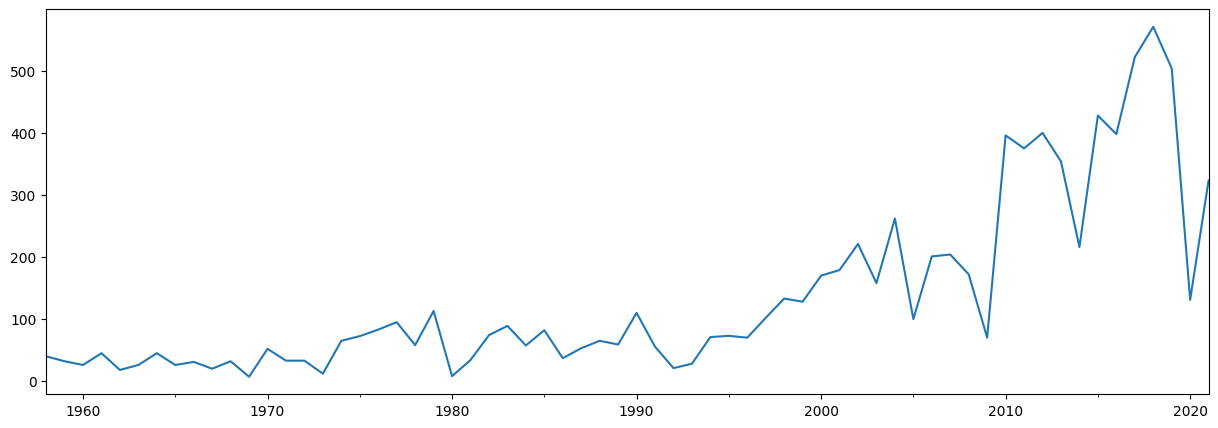

In [5]:
endog = constructorPoints['points']
endog.plot(figsize=(15, 5))


In [6]:
import statsmodels.api as sm

# Construct the model
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                 points   No. Observations:                   64
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -374.226
Date:                Wed, 08 Feb 2023   AIC                            754.452
Time:                        09:46:20   BIC                            760.929
Sample:                    12-31-1958   HQIC                           757.004
                         - 12-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     26.8864     26.374      1.019      0.308     -24.805      78.578
ar.L1          0.8092      0.089      9.116      0.000       0.635       0.983
sigma2      6905.5695   1012.449      6.821      0.0

In [7]:
fcast_res1 = res.get_forecast()

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

points        mean    mean_se  mean_ci_lower  mean_ci_upper
2022    288.649043  83.099756     151.962107     425.335978


In [8]:
print(res.forecast('2023'))


2022    288.649043
2023    260.449114
Freq: A-DEC, Name: predicted_mean, dtype: float64


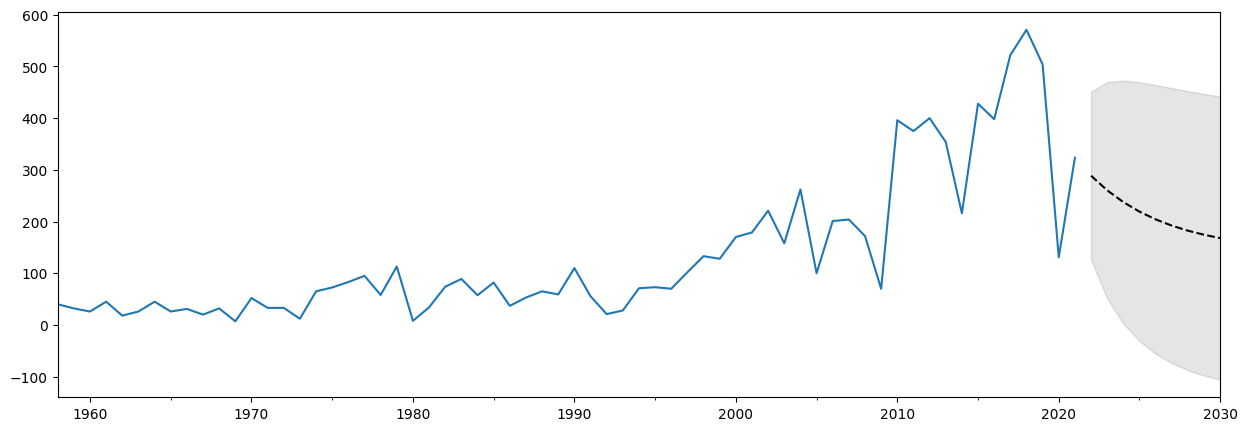

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['1958':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2030').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [10]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [11]:
test_stationarity(endog)

Test Statistic           1.684529
p-value                  0.998090
Lags                    10.000000
Observations            53.000000
Critical Value (1%)     -3.560242
Critical Value (5%)     -2.917850
Critical Value (10%)    -2.596796
dtype: float64


In [13]:
points = pd.DataFrame()
points['points'] = constructorPoints['points']


In [15]:
points['diff'] = points['points'] - points['points'].shift(1)
clear_data = points
clear_data

,points,diff
1958,40.0,NaN
1959,32.0,-8.0
1960,26.0,-6.0
1961,45.0,19.0
1962,18.0,-27.0
...,...,...
2017,522.0,124.0
2018,571.0,49.0
2019,504.0,-67.0
2020,131.0,-373.0


In [16]:
test_stationarity(clear_data['diff'].dropna(inplace=False))


Test Statistic          -3.031608
p-value                  0.032046
Lags                     9.000000
Observations            53.000000
Critical Value (1%)     -3.560242
Critical Value (5%)     -2.917850
Critical Value (10%)    -2.596796
dtype: float64


c:\Users\caros\anaconda3\envs\DataScience\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


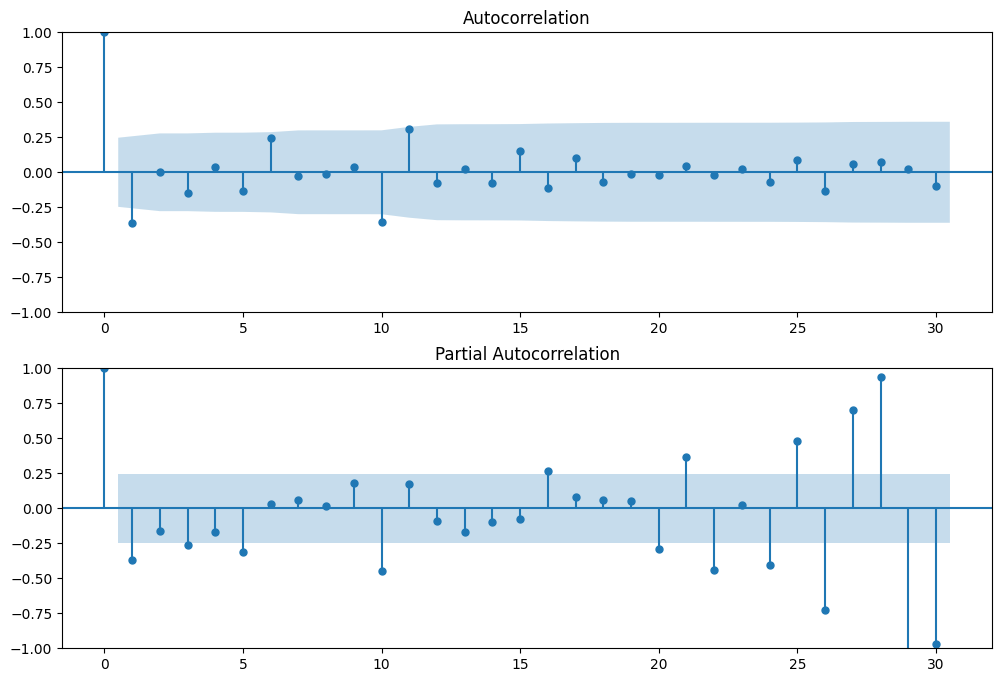

In [17]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(clear_data['diff'][1:], lags=30, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(clear_data['diff'][1:], lags=30, ax=ax2)

In [18]:
pd.plotting.register_matplotlib_converters()


In [19]:
clear_data

,points,diff
1958,40.0,NaN
1959,32.0,-8.0
1960,26.0,-6.0
1961,45.0,19.0
1962,18.0,-27.0
...,...,...
2017,522.0,124.0
2018,571.0,49.0
2019,504.0,-67.0
2020,131.0,-373.0


In [20]:
clear_data.index = clear_data.index.to_timestamp()
clear_data

,points,diff
1958-01-01,40.0,NaN
1959-01-01,32.0,-8.0
1960-01-01,26.0,-6.0
1961-01-01,45.0,19.0
1962-01-01,18.0,-27.0
...,...,...
2017-01-01,522.0,124.0
2018-01-01,571.0,49.0
2019-01-01,504.0,-67.0
2020-01-01,131.0,-373.0


                               SARIMAX Results                                
Dep. Variable:                 points   No. Observations:                   64
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -362.906
Date:                Wed, 08 Feb 2023   AIC                            735.812
Time:                        09:47:06   BIC                            746.528
Sample:                    01-01-1958   HQIC                           740.027
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8026      0.187     -4.286      0.000      -1.170      -0.436
ma.L1          0.3638      0.191      1.903      0.057      -0.011       0.738
ma.L2         -0.4346      0.134     -3.235      0.0

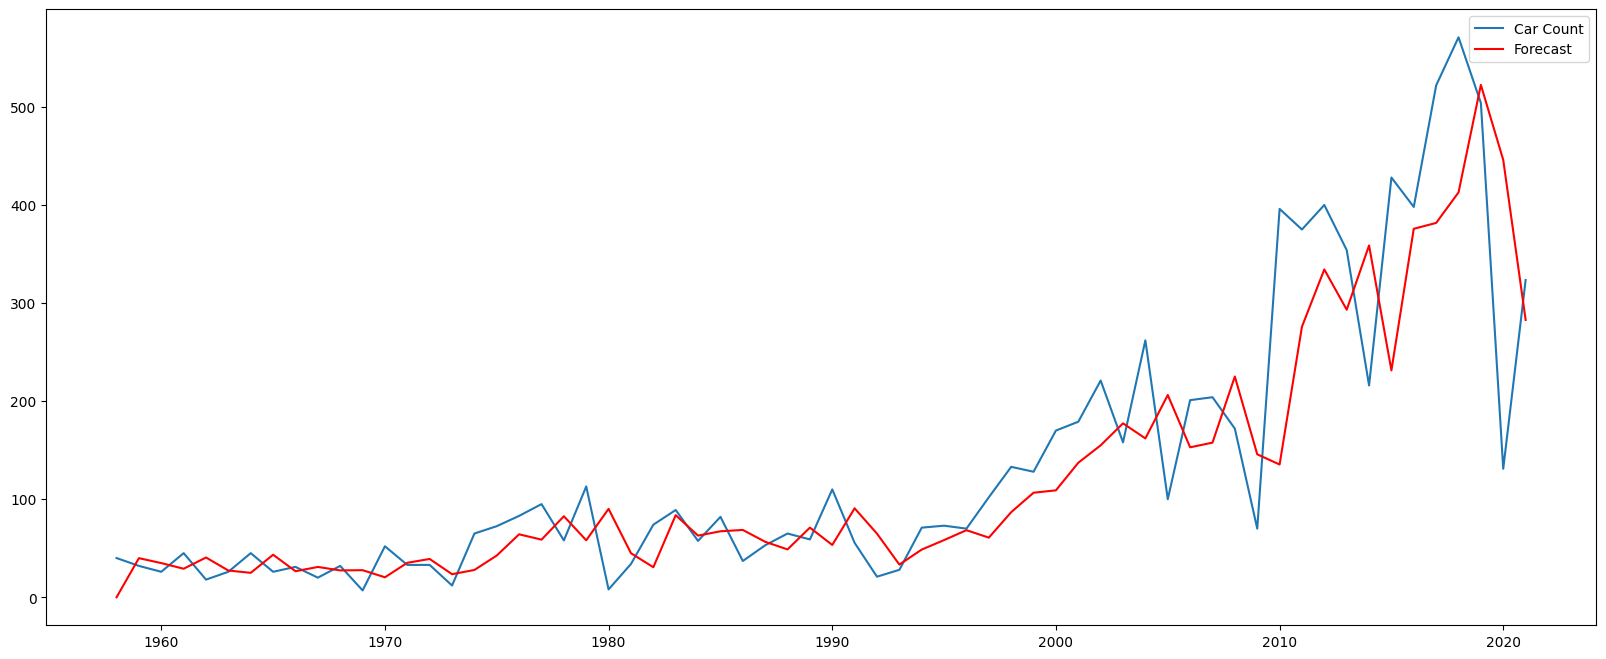

In [21]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['points'], order=(1,1,3)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['points'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])

print(results.summary())

In [22]:
clear_data

,points,diff
1958-01-01,40.0,NaN
1959-01-01,32.0,-8.0
1960-01-01,26.0,-6.0
1961-01-01,45.0,19.0
1962-01-01,18.0,-27.0
...,...,...
2017-01-01,522.0,124.0
2018-01-01,571.0,49.0
2019-01-01,504.0,-67.0
2020-01-01,131.0,-373.0


In [23]:
yearIndex = pd.DataFrame()
yearIndex = clear_data
yearIndex = yearIndex.reset_index()
yearIndex

,index,points,diff
0,1958-01-01,40.0,NaN
1,1959-01-01,32.0,-8.0
2,1960-01-01,26.0,-6.0
3,1961-01-01,45.0,19.0
4,1962-01-01,18.0,-27.0
...,...,...,...
59,2017-01-01,522.0,124.0
60,2018-01-01,571.0,49.0
61,2019-01-01,504.0,-67.0
62,2020-01-01,131.0,-373.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 points   No. Observations:                   64
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -363.819
Date:                Wed, 08 Feb 2023   AIC                            735.637
Time:                        09:54:22   BIC                            744.210
Sample:                    01-01-1958   HQIC                           739.009
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1873      1.305      0.144      0.886      -2.370       2.744
ma.L1         -0.6830      1.328     -0.514      0.607      -3.286       1.920
ma.L2         -0.0098      0.796     -0.012      0.990      -1.569       1.550
sigma2      6036.3504    697.063      8.660      0.000    4670.132    7402.569
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):               172.59
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              33.04   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

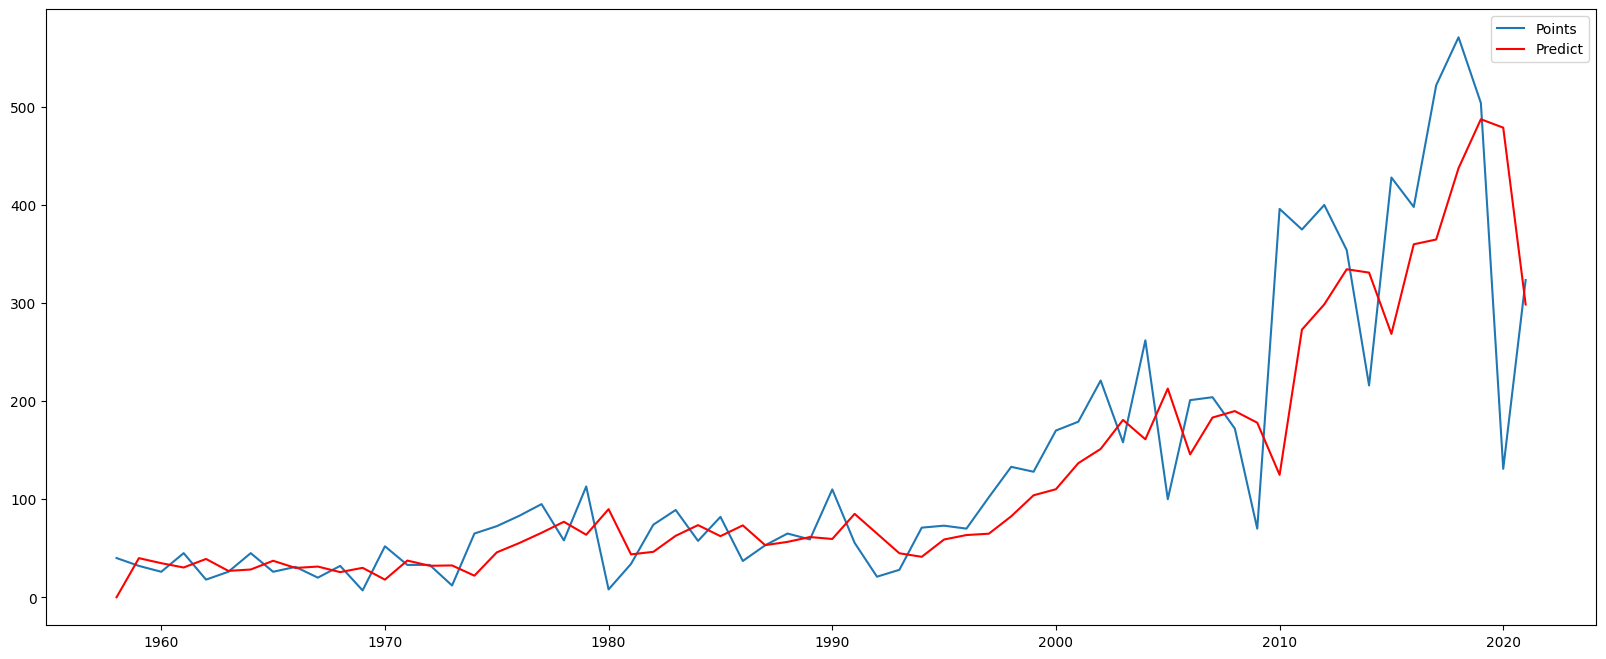

In [31]:
from statsmodels.tsa.arima.model import ARIMA

fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['points'].dropna(), order=(1,1,2)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['points'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Points', 'Forecast'])

results.summary()

In [32]:
import numpy as np
import pandas as pd

actual = clear_data['points']
forecast = results.fittedvalues

# Mean Absolute Error
mae = np.mean(np.abs(actual - forecast))
print("Mean Absolute Error:", mae)

# Mean Absolute Percentage Error
mape = np.mean(np.abs(actual - forecast) / actual)
print("Mean Absolute Percentage Error:", mape)

# Mean Error
me = np.mean(actual - forecast)
print("Mean Error:", me)

# Mean Percentage Error
mpe = np.mean((actual - forecast) / actual)
print("Mean Percentage Error:", mpe)

# Root Mean Squared Error
rmse = np.sqrt(np.mean((actual - forecast)**2))
print("Root Mean Squared Error:", rmse)

# Min-Max Error
min_max_error = np.max(actual) - np.min(actual)
print("Min-Max Error:", min_max_error)

# Correlation between actual and forecast
correlation = np.corrcoef(actual, forecast)[0,1]
print("Correlation between actual and forecast:", correlation)


Mean Absolute Error: 47.599729899367865
Mean Absolute Percentage Error: 0.6452916704746607
Mean Error: 13.55880915504107
Mean Percentage Error: -0.2734350429639759
Root Mean Squared Error: 77.24760062487566
Min-Max Error: 564.0
Correlation between actual and forecast: 0.8421001324358816


In [26]:
clear_data['points'][:1200]

1958-01-01     40.0
1959-01-01     32.0
1960-01-01     26.0
1961-01-01     45.0
1962-01-01     18.0
              ...  
2017-01-01    522.0
2018-01-01    571.0
2019-01-01    504.0
2020-01-01    131.0
2021-01-01    323.5
Freq: AS-JAN, Name: points, Length: 64, dtype: float64

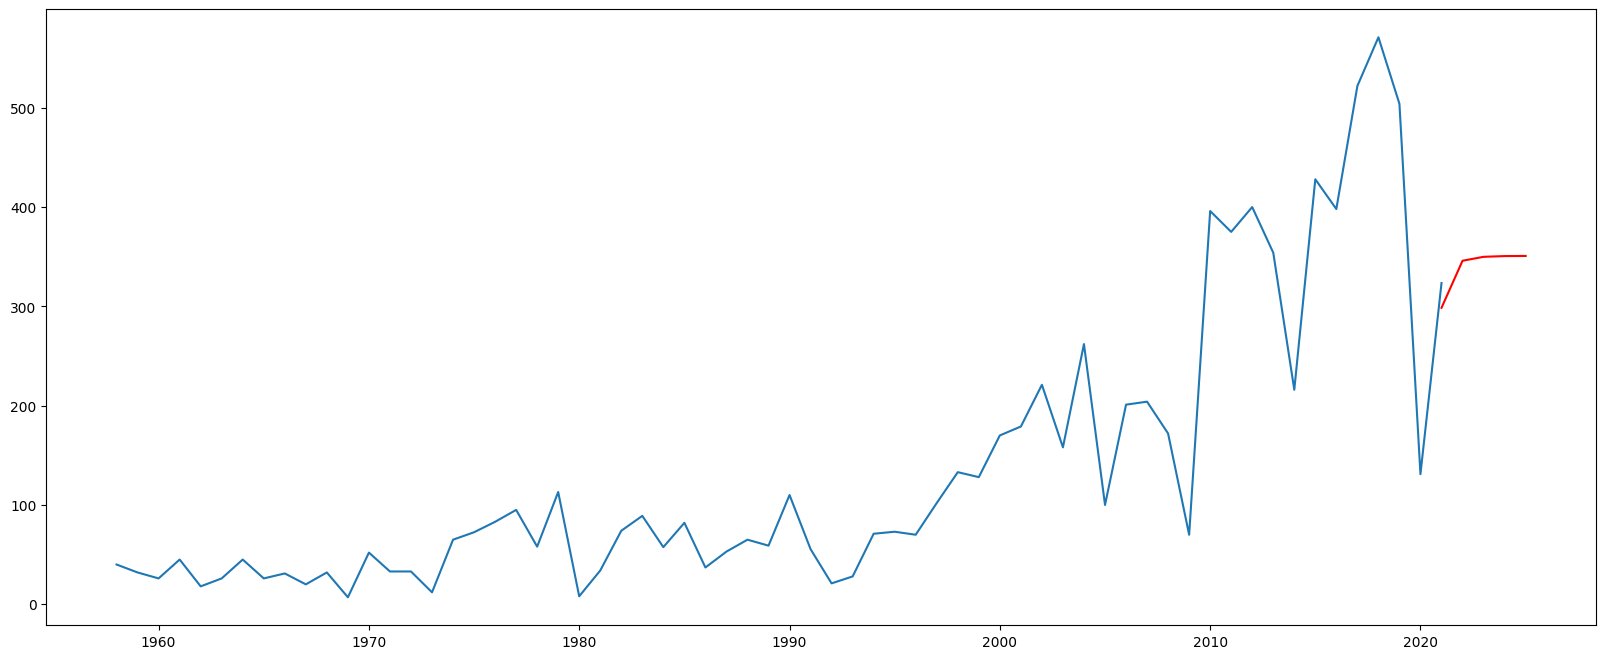

In [36]:

fig = plt.figure(figsize=(20,8))
x = results.predict(start=('2021-01-01'), end=('2025-01-01'), dynamic=False)

plt.plot(clear_data['points'])
plt.plot(x, color='r')

### Speed in Monza 

### Race duration in Monza

In [ ]:
results = pd.read_csv('results.csv')
races = pd.read_csv('races.csv')
races = races[['raceId', 'year', 'circuitId']]
results = results[['resultId', 'raceId', 'milliseconds', 'fastestLapSpeed', 'driverId']]

def timesCircuit(circuitId):
  resultsCircuit = pd.merge(races, results, on=['raceId'])
  resultsCircuit = resultsCircuit.loc[(resultsCircuit['circuitId'] == circuitId)]
  resultsCircuit = resultsCircuit[['milliseconds','year']]
  return resultsCircuit

times = pd.DataFrame()

#times['timeSpa'] = timesCircuit(13).groupby(['year']).min()

#times['timeSilverstone'] = timesCircuit(9).groupby(['year']).min()

#times['timeMonaco'] = timesCircuit(6).groupby(['year']).min()

timesMonza = timesCircuit(14)
missingRow = {'milliseconds':5887520, 'year':1980} 
timesMonza = timesMonza.append(missingRow, ignore_index=True)
timesMonza.sort_values('year', inplace=True)
timesMonza = timesMonza.groupby(['year']).min()

timesMonza['milliseconds'] = timesMonza['milliseconds'].astype('int')
timesMonza['milliseconds'] = timesMonza['milliseconds'].apply(lambda x: x/60000)


timesMonza

In [ ]:
timesMonza.index = pd.period_range('1950', '2021', freq='Y')
timesMonza


In [ ]:
endog = timesMonza['milliseconds']
endog.plot(figsize=(15, 5))


In [ ]:
import statsmodels.api as sm

# Construct the model
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

In [ ]:
fcast_res1 = res.get_forecast()

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

In [ ]:
print(res.forecast('2023'))


In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['1950':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2030').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [ ]:
def speedCircuits(circuitId):
  results = pd.read_csv('results.csv')
  races = pd.read_csv('races.csv')
  races = races[['raceId', 'year', 'circuitId']]
  results = results[['resultId', 'raceId', 'fastestLapTime', 'fastestLapSpeed', 'driverId']]
  resultsCircuit = pd.merge(races, results, on=['raceId'])
  resultsCircuit = resultsCircuit.loc[(resultsCircuit['circuitId'] == circuitId)]
  resultsCircuit = resultsCircuit[['fastestLapSpeed','year']]
  resultsCircuit = resultsCircuit.loc[(resultsCircuit['fastestLapSpeed']!="\\N")]
  resultsCircuit['fastestLapSpeed'] = resultsCircuit['fastestLapSpeed'].astype(float)
  return resultsCircuit

speed = pd.DataFrame()
speed['meanSpeedMonza'] = speedCircuits(14).groupby(['year']).mean()
speed['maxSpeedMonza'] = speedCircuits(14).groupby(['year']).max()
#speed['meanSpeedSpa'] = speedCircuits(13).groupby(['year']).mean()
#speed['maxSpeedSpa'] = speedCircuits(13).groupby(['year']).max()
#speed['meanSpeedSilverstone'] = speedCircuits(9).groupby(['year']).mean()
#speed['maxSpeedSilverstone'] = speedCircuits(9).groupby(['year']).max()
#speed['meanSpeedMonaco'] = speedCircuits(6).groupby(['year']).mean()
#speed['maxSpeedMonaco'] = speedCircuits(6).groupby(['year']).max()
speed



In [ ]:
speed.index = pd.period_range('2004', '2021', freq='Y')
speed.head()


In [ ]:
endog = speed['maxSpeedMonza']
endog.plot(figsize=(15, 5))


In [ ]:
import statsmodels.api as sm

# Construct the model
mod = sm.tsa.SARIMAX(endog, order=(1, 0, 0), trend='c')
# Estimate the parameters
res = mod.fit()

print(res.summary())

In [ ]:
fcast_res1 = res.get_forecast()

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

In [ ]:
print(res.forecast('2023'))


In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
endog.loc['2004':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast('2025').summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [ ]:
test_stationarity(endog)

In [ ]:
fig, axes = plt.subplots(3, 2, sharex=True)

In [ ]:
points = pd.DataFrame()
points['maxSpeedMonza'] = speed['maxSpeedMonza']


In [ ]:
points.info()


In [ ]:
points['diff'] = points['maxSpeedMonza'] - points['maxSpeedMonza'].shift(1)
clear_data = points
clear_data

In [ ]:
test_stationarity(clear_data['diff'].dropna(inplace=False))


In [ ]:
points['diff2'] = points['diff'] - points['diff'].shift(1)
clear_data = points
clear_data

In [ ]:
test_stationarity(clear_data['diff2'].dropna(inplace=False))

In [ ]:
# ACF, PACF graphs to help determine order of ARIMA model, again statsmodel has these handy functions built-in
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(clear_data['diff2'][1:], lags=1, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(clear_data['diff2'][1:], lags=1, ax=ax2)

In [ ]:
pd.plotting.register_matplotlib_converters()


In [ ]:
clear_data

In [ ]:
clear_data.reset_index()


In [ ]:
yearIndex = pd.DataFrame()
yearIndex = clear_data
yearIndex = yearIndex.reset_index()
yearIndex

In [ ]:
fig = plt.figure(figsize=(20,8))
model = ARIMA(clear_data['maxSpeedMonza'], order=(1,2,0)) 
ax = plt.gca()
results = model.fit() 
plt.plot(clear_data['maxSpeedMonza'])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Car Count', 'Forecast'])

print(results.summary())

## Miscellanous


The code below, although not part of the project, is still included because it contains useful code for future and further analysis. 

### Boxplot - Pace race Monza 2019

In [ ]:
import fastf1 as ff1
from fastf1 import plotting

import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm

import numpy as np

In [ ]:
# Enable the cache
ff1.Cache.enable_cache('/content/gdrive/MyDrive/cacheF1') 

# Get rid of an error
pd.options.mode.chained_assignment = None

In [ ]:
# Load the session data
race = ff1.get_session(2019, 'Italy', 'R')

# Get the laps
laps = race.load_laps()

In [ ]:

# Convert laptimes to seconds
laps['LapTimeSeconds'] = laps['LapTime'].dt.total_seconds()

# To get accurate laps only, we exclude in- and outlaps
laps = laps.loc[(laps['PitOutTime'].isnull() & laps['PitInTime'].isnull())]

In [ ]:
# Also, we remove outliers since those don't represent the racepace,
# using the Inter-Quartile Range (IQR) proximity rule
q75, q25 = laps['LapTimeSeconds'].quantile(0.75), laps['LapTimeSeconds'].quantile(0.25)

intr_qr = q75 - q25

laptime_max = q75 + (1.5 * intr_qr) # IQR proximity rule: Max = q75 + 1,5 * IQR
laptime_min = q25 - (1.5 * intr_qr) # IQR proximity rule: Min = q25 + 1,5 * IQR

laps.loc[laps['LapTimeSeconds'] < laptime_min, 'LapTimeSeconds'] = np.nan
laps.loc[laps['LapTimeSeconds'] > laptime_max, 'LapTimeSeconds'] = np.nan

In [ ]:
drivers_to_visualize = ['LEC', 'VER', 'HAM', 'VET']

In [ ]:
# To make sure we won't get any equally styled lines when comparing teammates
visualized_teams = []

# Make plot a bit bigger
plt.rcParams['figure.figsize'] = [10, 10]

# Create 2 subplots (1 for the boxplot, 1 for the lap-by-lap comparison)
fig, ax = plt.subplots(2)


##############################
#
# Boxplot for average racepace
#
##############################
laptimes = [laps.pick_driver(x)['LapTimeSeconds'].dropna() for x in drivers_to_visualize] 

ax[0].boxplot(laptimes, labels=drivers_to_visualize)

ax[0].set_title('Comparazione del passo gara media')
ax[0].set(ylabel = 'Tempi del giro (s)')



##############################
#
# Lap-by-lap racepace comparison
#
##############################
for driver in drivers_to_visualize:
    driver_laps = laps.pick_driver(driver)[['LapNumber', 'LapTimeSeconds', 'Team']]
    
    # Select all the laps from that driver
    driver_laps = driver_laps.dropna()
    
    # Extract the team for coloring purploses
    team = pd.unique(driver_laps['Team'])[0]
    
    # X-coordinate is the lap number
    x = driver_laps['LapNumber']
    
    # Y-coordinate a smoothed line between all the laptimes
    poly = np.polyfit(driver_laps['LapNumber'], driver_laps['LapTimeSeconds'], 5)
    y_poly = np.poly1d(poly)(driver_laps['LapNumber'])
    
    # Make sure that two teammates don't get the same line style
    linestyle = '-' if team not in visualized_teams else ':'
    
    # Plot the data
    ax[1].plot(x, y_poly, label=driver, color=ff1.plotting.team_color(team), linestyle=linestyle)
    
    # Include scatterplot (individual laptimes)
    # y = driver_laps['LapTimeSeconds']
    # scatter_marker = 'o' if team not in visualized_teams else '^' 
    # ax[1].scatter(x, y, label=driver, color=ff1.plotting.team_color(team), marker=scatter_marker)
    
    # Append labels
    ax[1].set(ylabel = 'Tempi del giro (s)')
    ax[1].set(xlabel = 'Giro')
    
    # Set title
    ax[1].set_title('Passo gara giro per giro')

    # Generate legend
    ax[1].legend()
    
    # Add the team to the visualized teams variable so that the next time the linestyle will be different
    visualized_teams.append(team)
    


### Telemetry analysis #1

In [ ]:
import matplotlib.pyplot as plt
import fastf1.plotting



# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl()

# load a session and its telemetry data
session = fastf1.get_session(2021, 'Spanish Grand Prix', 'Q')
session.load()

In [ ]:
ver_lap = session.laps.pick_driver('VER').pick_fastest()
ham_lap = session.laps.pick_driver('HAM').pick_fastest()

In [ ]:
ver_tel = ver_lap.get_car_data().add_distance()
ham_tel = ham_lap.get_car_data().add_distance()

In [ ]:
rbr_color = fastf1.plotting.team_color('RBR')
mer_color = fastf1.plotting.team_color('MER')

fig, ax = plt.subplots()
ax.plot(ver_tel['Distance'], ver_tel['Speed'], color=rbr_color, label='VER')
ax.plot(ham_tel['Distance'], ham_tel['Speed'], color=mer_color, label='HAM')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Qualifying")

plt.show()

### Telemetry analysis #2


In [ ]:
import matplotlib.pyplot as plt
import fastf1.plotting



# enable some matplotlib patches for plotting timedelta values and load
# FastF1's default color scheme
fastf1.plotting.setup_mpl()

# load a session and its telemetry data
session = fastf1.get_session(2019, 'Italian Grand Prix', 'R')
session.load()

In [ ]:
lec_lap = session.laps.pick_driver('LEC').pick_accurate()
#lec_lap = lec_lap.loc[(lec_lap['LapNumber']>=10) & (lec_lap['LapNumber']<=30)]
#lec_lap = session.laps.pick_driver('LEC').pick_fastest()

lec_tel = lec_lap.get_car_data().add_distance()

lec_tel

In [ ]:
fer_color = fastf1.plotting.team_color('FER')

fig, ax = plt.subplots()
ax.plot(lec_tel['SessionTime'], lec_tel['Speed'], color=fer_color, label='LEC')
ax.set_xlabel('Durata gara in formato h:mm')
ax.set_ylabel('Velocità in km/h')

ax.legend()
plt.suptitle(f"Telemetria di tutti i di Leclerc \n "
             f"{session.event['EventName']} {session.event.year} Race")

fig.set_figwidth(50)
fig.set_figheight(10)

plt.show()

### Telemetry analysis #3


In [ ]:
lec_lap = session.laps.pick_driver('LEC').pick_accurate()
lec_lap = lec_lap.loc[(lec_lap['LapNumber']>10) & (lec_lap['LapNumber']<30)]
#lec_lap = session.laps.pick_driver('LEC').pick_fastest()



allLaps = session.laps.pick_driver('LEC').pick_accurate()

  

lap1 = lec_lap.loc[lec_lap['LapNumber'] == 11]
tel1 = lap1.get_car_data().add_distance()

lap5 = lec_lap.loc[lec_lap['LapNumber'] == 12]
tel2 = lap5.get_car_data().add_distance()

lap10 = lec_lap.loc[lec_lap['LapNumber'] == 13]
tel3= lap10.get_car_data().add_distance()

lap15 =lec_lap.loc[lec_lap['LapNumber'] == 14]
tel4 = lap15.get_car_data().add_distance()

lap20 = lec_lap.loc[lec_lap['LapNumber'] == 15]
tel5 = lap20.get_car_data().add_distance()

lap25 =lec_lap.loc[lec_lap['LapNumber'] == 16]
tel6 = lap25.get_car_data().add_distance()

lap30 = lec_lap.loc[lec_lap['LapNumber'] == 17]
tel7 = lap30.get_car_data().add_distance()

lap35 = lec_lap.loc[lec_lap['LapNumber'] == 18]
tel8 = lap35.get_car_data().add_distance()

lap40 = lec_lap.loc[lec_lap['LapNumber'] == 19]
tel9 = lap40.get_car_data().add_distance()

lap45 = lec_lap.loc[lec_lap['LapNumber'] == 23]
tel10 = lap45.get_car_data().add_distance()

lap50 = lec_lap.loc[lec_lap['LapNumber'] == 22]
tel11 = lap50.get_car_data().add_distance()



In [ ]:
fig, ax = plt.subplots()
ax.plot(tel1['Distance'], tel1['Speed'], color='red', label='Lap11')
ax.plot(tel2['Distance'], tel2['Speed'], color='white', label='Lap12')
ax.plot(tel3['Distance'], tel3['Speed'], color='yellow', label='Lap13')
ax.plot(tel4['Distance'], tel4['Speed'], color='blue', label='Lap14')
ax.plot(tel5['Distance'], tel5['Speed'], color='green', label='Lap15')

ax.set_xlabel('Distance in m')
ax.set_ylabel('Speed in km/h')

ax.legend()
plt.suptitle(f"Fastest Lap Comparison \n "
             f"{session.event['EventName']} {session.event.year} Race")

fig.set_figwidth(20)
fig.set_figheight(5)

plt.show()